Made by Egor Dudyrev

Data:
* images: https://www.dropbox.com/sh/dnmsninmmp713z2/AABHeitmojm0-XD7_Ro6ZeWha?dl=0
* elbow.txt: https://www.dropbox.com/s/wi1som52h8vo6ez/elbow.txt?dl=0

# Task 1 (10 points). Image clustering

You need to cluster one of the attached images (or choose your own) using the color description of
each pixel. You can add pixel coordinates as features. The clustering procedure outputs:
1. Cluster centroids (as pixel colors);
2. The compressed image where pixel colors are replaced with corresponding cluster centroid’s color;
3. Compare the amount of memory needed to store the original and compressed image.

Choose the number of clusters ad hoc between 4 and 16. Here is a small tutorial about obtaining color
description of a pixel.

In [1]:
# Import libraries
from imageio import imread, imsave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import pickle
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error

In [2]:
def get_features(fname, add_indices=False):
    img = imread(fname)
    if add_indices:
        ind = np.indices(img.shape[:2]).transpose(1 ,2 ,0)
        features = np.dstack((ind, img)).reshape(-1, 5)
    else:
        features = img.reshape(-1,3)
    return img, features

In [3]:
def test_nclusters(data, n_clusters, algo):
    km = algo(n_clusters=n_clusters)
    km.fit(data)
    labels = km.predict(data)
    return km, labels

## Load the data

Define filenames to load and to save

In [4]:
fname = '../data/landscape6.jpg'
fname_clust = '../data/landscape6_clustered.jpg'

Preprocess file with a code given in the task. Get image features to cluster on

In [5]:
img, features = get_features(fname, add_indices=False)

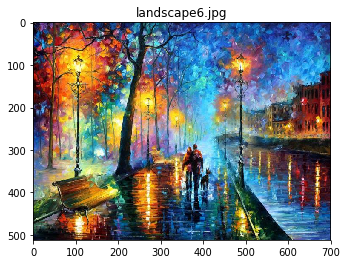

In [6]:
plt.imshow(img)
plt.title(fname.split('/')[-1])
plt.show()

## Choose best num of clusters

Iterate through each possible num of clusters and find how good it approximates original image.

In [7]:
nclusters = list(range(4,17))
maes = []
for n in tqdm(nclusters):
    km, labels = test_nclusters(features, n, KMeans)
    new_img = km.cluster_centers_[labels]
    maes.append(mean_absolute_error(features, new_img))

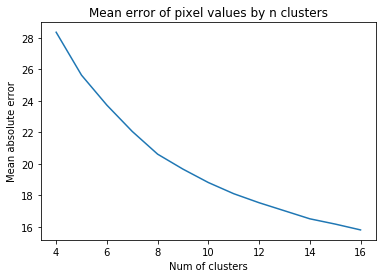

In [8]:
plt.plot(nclusters, maes)
plt.title('Mean error of pixel values by n clusters')
plt.xlabel('Num of clusters')
plt.ylabel('Mean absolute error')
plt.show()

There's no obvious threshold for num of clusters. So let's choose 8 as a beautiful number.

## Clustering the image

Calculate clusters and get new clustered image from them

In [9]:
km, labels = test_nclusters(features, 8, KMeans)
new_img = km.cluster_centers_[labels].round(0).astype(int).reshape(img.shape)
imsave(fname_clust, new_img.astype(np.uint8))

Visualy compare images 

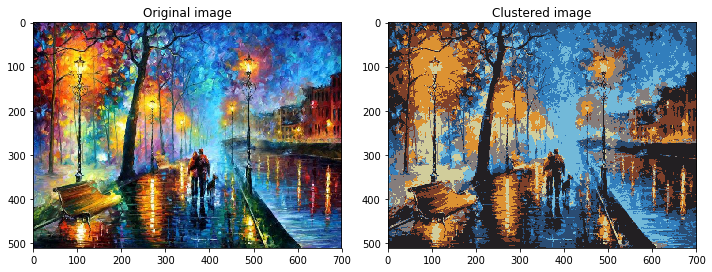

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(img)
plt.title('Original image')

plt.subplot(122)
plt.imshow(new_img)
plt.title('Clustered image')

plt.tight_layout()
plt.show()

We lost green color on the image. But the main idea of the picture is still visible.

In [11]:
orig_size = os.path.getsize(fname)
new_size = os.path.getsize(fname_clust.replace('.pickle','.jpg'))
print(f'Original image size: {orig_size/1000}kB, clustered image size: {new_size/1000}kB, Size reduction: {1-new_size/orig_size:.2%}')

Original image size: 178.31kB, clustered image size: 105.355kB, Size reduction: 40.91%


# Task 2 (10 points). Determine the optimal number of clusters

Remember the K-Means method optimises the following criteria:
$$ J(R) = \sum_{i=1}^{k}\sum_{j \in R'_i} d(c_i, y_j) $$
where $R'_i$ is the i-th cluster, $c_i$ is the centroid of the i-th cluster, $y_j$ is a data-point in i-th cluster, and d($\cdot$, $\cdot$) is the distance between objects.

The “Elbow method” is one of the approaches for making decisions on the number of clusters for the
K-Means method. The idea is to calculate the target function J(R) for every natural number k from a
certain range. The optimal number of clusters is defined as the value of k, starting with which the value
of J(R) does not decrease so sharply. For example, the number of classes defined by figure 1 can be
chosen equal to 4.

Using the data from elbow.txt and the elbow method, define the optimal number of clusters.

In [12]:
elbow_ds = pd.read_csv('../data/elbow.txt', header=None, sep='\t', decimal=',')
print(elbow_ds.shape)
elbow_ds.head()

(500, 2)


,0,1
0,-2.747711,3.575680
1,-1.939473,1.658946
2,-2.264922,2.754515
3,-1.963531,3.247520
4,-1.379661,2.885197


In [13]:
nclusters = np.arange(2,15)
sils = []
for n in tqdm(nclusters):
    km, labels = test_nclusters(elbow_ds[[0,1]], n, KMeans)
    elbow_ds[f'clusters_{n}'] = labels
    sils.append( silhouette_score(elbow_ds[[0,1]], labels) )

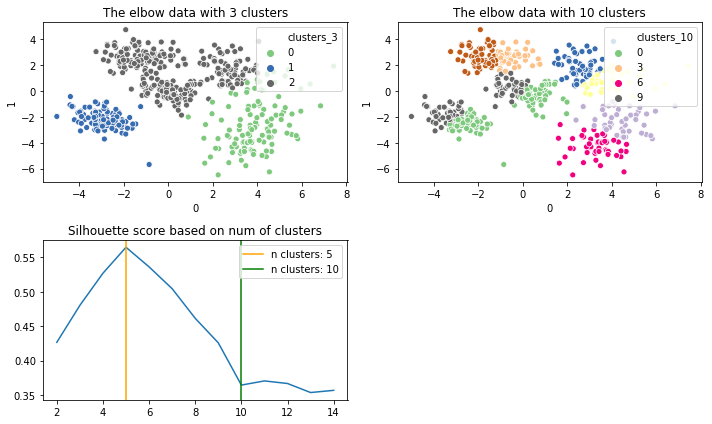

In [14]:
plt.figure(figsize=(10,6))
plt.subplot(221)
sns.scatterplot(0, 1, hue='clusters_3', data=elbow_ds, palette='Accent')
plt.title('The elbow data with 3 clusters')

plt.subplot(222)
sns.scatterplot(0, 1, hue='clusters_10', data=elbow_ds, palette='Accent')
plt.title('The elbow data with 10 clusters')

plt.subplot(223)
plt.plot(nclusters, sils)
plt.axvline(5, label='n clusters: 5', color='orange')
plt.axvline(10, label='n clusters: 10', color='green')
plt.legend()
plt.title('Silhouette score based on num of clusters')

plt.tight_layout()
plt.show()

The optimal number of clusters is obviously 5 as it has the best Silhouette score.

But if we are looking for "he value of k, starting with which the value of J(R) does not decrease so sharply" then the optimal number will be 10.